# Zadanie 7 - Alexnet
### Aleksandra Jonas, Aleksandra Gronowska, Iwona Christop

## Przygotowanie danych

In [1]:
from IPython.display import Image, SVG, display

In [2]:
import sys
import subprocess
import pkg_resources
import numpy as np

required = { 'scikit-image'}
installed = {pkg.key for pkg in pkg_resources.working_set}
missing = required - installed
# Alexnet requires images to be of dim = (227, 227, 3)
newSize = (227,227)

if missing: 
    python = sys.executable
    subprocess.check_call([python, '-m', 'pip', 'install', *missing], stdout=subprocess.DEVNULL)

def load_train_data(input_dir):
    import numpy as np
    import pandas as pd
    import os
    from skimage.io import imread
    import cv2 as cv
    from pathlib import Path
    import random
    from shutil import copyfile, rmtree
    import json

    import seaborn as sns
    import matplotlib.pyplot as plt

    import matplotlib
    
    image_dir = Path(input_dir)
    categories_name = []
    for file in os.listdir(image_dir):
        d = os.path.join(image_dir, file)
        if os.path.isdir(d):
            categories_name.append(file)

    folders = [directory for directory in image_dir.iterdir() if directory.is_dir()]

    train_img = []
    categories_count=[]
    labels=[]
    for i, direc in enumerate(folders):
        count = 0
        for obj in direc.iterdir():
            if os.path.isfile(obj) and os.path.basename(os.path.normpath(obj)) != 'desktop.ini':
                labels.append(os.path.basename(os.path.normpath(direc)))
                count += 1
                img = imread(obj)#zwraca ndarry postaci xSize x ySize x colorDepth
                img = img[:, :, :3]
                img = cv.resize(img, newSize, interpolation=cv.INTER_AREA)# zwraca ndarray
                img = img / 255 #normalizacja
                train_img.append(img)
        categories_count.append(count)
    X={}
    X["values"] = np.array(train_img)
    X["categories_name"] = categories_name
    X["categories_count"] = categories_count
    X["labels"]=labels
    return X

def load_test_data(input_dir):
    import numpy as np
    import pandas as pd
    import os
    from skimage.io import imread
    import cv2 as cv
    from pathlib import Path
    import random
    from shutil import copyfile, rmtree
    import json

    import seaborn as sns
    import matplotlib.pyplot as plt

    import matplotlib

    image_path = Path(input_dir)

    labels_path = image_path.parents[0] / 'test_labels.json'

    jsonString = labels_path.read_text()
    objects = json.loads(jsonString)

    categories_name = []
    categories_count=[]
    count = 0
    c = objects[0]['value']
    for e in  objects:
        if e['value'] != c:
            categories_count.append(count)
            c = e['value']
            count = 1
        else:
            count += 1
        if not e['value'] in categories_name:
            categories_name.append(e['value'])

    categories_count.append(count)
    
    test_img = []

    labels=[]
    for e in objects:
        p = image_path / e['filename']
        img = imread(p)#zwraca ndarry postaci xSize x ySize x colorDepth
        img = img[:, :, :3]
        img = cv.resize(img, newSize, interpolation=cv.INTER_AREA)# zwraca ndarray
        img = img / 255#normalizacja
        test_img.append(img)
        labels.append(e['value'])

    X={}
    X["values"] = np.array(test_img)
    X["categories_name"] = categories_name
    X["categories_count"] = categories_count
    X["labels"]=labels
    return X

In [3]:
# Data load
data_train = load_train_data("./train_test_sw/train_sw")
values_train = data_train['values']
labels_train = data_train['labels']

data_test = load_test_data("./train_test_sw/test_sw")
X_test = data_test['values']
y_test = data_test['labels']

In [4]:
from sklearn.model_selection import train_test_split

In [5]:
X_train, X_validate, y_train, y_validate = train_test_split(values_train, labels_train, test_size=0.2, random_state=42)

In [6]:
from sklearn.preprocessing import LabelEncoder

In [7]:
class_le = LabelEncoder()
y_train_enc = class_le.fit_transform(y_train)
y_validate_enc = class_le.fit_transform(y_validate)
y_test_enc = class_le.fit_transform(y_test)

In [8]:
import tensorflow as tf

In [9]:
train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train_enc))
validation_ds = tf.data.Dataset.from_tensor_slices((X_validate, y_validate_enc))
test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test_enc))

In [10]:
train_ds_size = tf.data.experimental.cardinality(train_ds).numpy()
test_ds_size = tf.data.experimental.cardinality(test_ds).numpy()
validation_ds_size = tf.data.experimental.cardinality(validation_ds).numpy()
print("Training data size:", train_ds_size)
print("Test data size:", test_ds_size)
print("Validation data size:", validation_ds_size)

Training data size: 820
Test data size: 259
Validation data size: 206


In [11]:
train_ds = (train_ds
                  .shuffle(buffer_size=train_ds_size)
                  .batch(batch_size=32, drop_remainder=True))
test_ds = (test_ds
                  .shuffle(buffer_size=train_ds_size)
                  .batch(batch_size=32, drop_remainder=True))
validation_ds = (validation_ds
                  .shuffle(buffer_size=train_ds_size)
                  .batch(batch_size=32, drop_remainder=True))

## Model 1 - batch size = 32

In [12]:
from tensorflow import keras
import os
import time

In [13]:
model = keras.models.Sequential([
    keras.layers.Conv2D(filters=96, kernel_size=(11,11), strides=(4,4), activation='relu', input_shape=(227,227,3)),
    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    keras.layers.Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), activation='relu', padding="same"),
    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    keras.layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    keras.layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    keras.layers.Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    keras.layers.Flatten(),
    keras.layers.Dense(4096, activation='relu'),
    keras.layers.Dense(4096, activation='relu'),
    keras.layers.Dense(10, activation='softmax')
])

In [14]:
root_logdir = os.path.join(os.curdir, "logs\\fit\\")
def get_run_logdir():
    run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
    return os.path.join(root_logdir, run_id)
run_logdir = get_run_logdir()
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)

In [15]:
model.compile(loss='sparse_categorical_crossentropy', optimizer=tf.optimizers.SGD(lr=.001), metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 55, 55, 96)        34944     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 27, 27, 96)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 27, 27, 256)       614656    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 13, 13, 256)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 13, 13, 384)       885120    
                                                                 
 conv2d_3 (Conv2D)           (None, 13, 13, 384)       1

In [16]:
model.fit(train_ds,
          epochs=100,
          validation_data=validation_ds,
          validation_freq=1,
          callbacks=[tensorboard_cb])

Epoch 1/100
25/25 [==============================] - 53s 2s/step - loss: 2.2516 - accuracy: 0.2150 - val_loss: 2.1732 - val_accuracy: 0.2656
Epoch 2/100
25/25 [==============================] - 40s 2s/step - loss: 1.9127 - accuracy: 0.2362 - val_loss: 1.6225 - val_accuracy: 0.2188
Epoch 3/100
25/25 [==============================] - 40s 2s/step - loss: 1.6217 - accuracy: 0.2612 - val_loss: 1.5785 - val_accuracy: 0.3438
Epoch 4/100
25/25 [==============================] - 41s 2s/step - loss: 1.5799 - accuracy: 0.3038 - val_loss: 1.5517 - val_accuracy: 0.2917
Epoch 5/100
25/25 [==============================] - 41s 2s/step - loss: 1.5565 - accuracy: 0.2988 - val_loss: 1.5266 - val_accuracy: 0.3750
Epoch 6/100
25/25 [==============================] - 41s 2s/step - loss: 1.4953 - accuracy: 0.3738 - val_loss: 1.6185 - val_accuracy: 0.3750
Epoch 7/100
25/25 [==============================] - 41s 2s/step - loss: 1.4873 - accuracy: 0.3613 - val_loss: 1.4834 - val_accuracy: 0.4219
Epoch 8/100
2

In [17]:
model.evaluate(test_ds)

8/8 [==============================] - 7s 327ms/step - loss: 1.0574 - accuracy: 0.7070


[1.0574449300765991, 0.70703125]

## Wizualizacja filtrów obrazowych na poszczególnych warstwach

In [18]:
layers_names = []
for layer in model.layers:
    # check for convolutional layer
    if 'conv' not in layer.name:
        continue
    layers_names.append(layer.name)
    filters, biases = layer.get_weights()
    print(layer.name, filters.shape)

conv2d (11, 11, 3, 96)
conv2d_1 (5, 5, 96, 256)
conv2d_2 (3, 3, 256, 384)
conv2d_3 (3, 3, 384, 384)
conv2d_4 (3, 3, 384, 256)


In [19]:
import matplotlib.pyplot as plt

In [20]:
filters, biases = model.layers[0].get_weights()
fmin, fmax = filters.min(), filters.max()
filters = (filters - fmin) / (fmax - fmin)

In [21]:
nb_filters, tmp = 3, 1

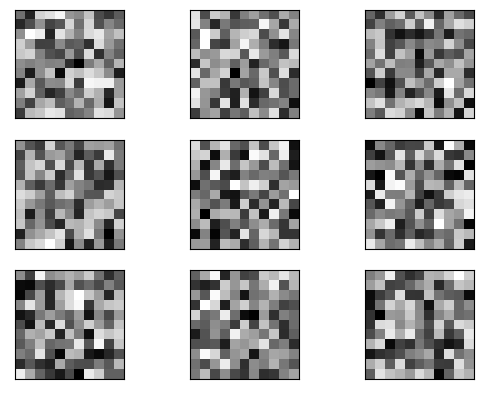

In [22]:
for i in range(nb_filters):
    f = filters[:, :, :, i]
    for j in range(3):
        ax = plt.subplot(nb_filters, 3, tmp)
        ax.set_xticks([])
        ax.set_yticks([])
        plt.imshow(f[:, :, j], cmap='gray')
        tmp += 1
plt.show()

In [23]:
img_width, img_height = 227, 227

In [24]:
layer = model.get_layer(name=layers_names[0])
feature_extractor = keras.Model(inputs=model.inputs, outputs=layer.output)

In [25]:
def initialize_image():
    # random noisy img
    img = tf.random.uniform((1, img_width, img_height, 3))
    return img

In [26]:
def loss_calc(input_image, filter_index, fex):
    activation = fex(input_image)
    # getting rid of the border pixels so they don't inlfuence our results in any fun way
    filter_activation = activation[:, 2:-2, 2:-2, filter_index]
    return tf.reduce_mean(filter_activation)

In [27]:
def gradient_ascent_step(img, filter_index, learning_rate, fex):
    with tf.GradientTape() as tape:
        tape.watch(img)
        loss = loss_calc(img, filter_index, fex)
    grads = tape.gradient(loss, img)
    grads = tf.math.l2_normalize(grads)
    img += learning_rate * grads
    return loss, img

In [28]:
def deprocess_image(img):
    img -= img.mean()
    img /= img.std() + 1e-5
    img *= 0.15

    img = img[25:-25, 25:-25, :]

    img += 0.5
    img = np.clip(img, 0, 1)

    img *= 255
    img = np.clip(img, 0, 255).astype("uint8")
    return img

In [29]:
def visualize_filter(filter_index, fex):
    # 20 steps grad desc
    iterations = 30
    learning_rate = 10.0
    img = initialize_image()
    for iteration in range(iterations):
        loss, img = gradient_ascent_step(img, filter_index, learning_rate, fex)
    img = deprocess_image(img[0].numpy())
    return loss, img

In [30]:
loss, img = visualize_filter(0, feature_extractor)
keras.preprocessing.image.save_img("lab7props/0.png", img)

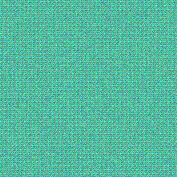

In [31]:
display(Image("lab7props/0.png"))

In [32]:
def visualize_layer(layer_name, n):
    from IPython.display import Image, display
    
    layer = model.get_layer(name=layer_name)
    fex = keras.Model(inputs=model.inputs, outputs=layer.output)
    
    print(f"Getting started with layer {layer_name}")
    all_imgs = []
    for filter_index in range(n**2):
        # print("Processing filter %d" % (filter_index,))
        loss, img = visualize_filter(filter_index, fex)
        all_imgs.append(img)

    margin = 5
    cropped_width = img_width - 25 * 2
    cropped_height = img_height - 25 * 2
    width = n * cropped_width + (n - 1) * margin
    height = n * cropped_height + (n - 1) * margin
    stitched_filters = np.zeros((width, height, 3))

    for i in range(n):
        for j in range(n):
            img = all_imgs[i * n + j]
            stitched_filters[
                (cropped_width + margin) * i : (cropped_width + margin) * i + cropped_width,
                (cropped_height + margin) * j : (cropped_height + margin) * j
                + cropped_height,
                :,
            ] = img

    filename = f"lab7props/{layer_name}_stitched_filters.png"
    keras.preprocessing.image.save_img(filename, stitched_filters)
    print(f"{layer_name} done")

In [33]:
layers_names

['conv2d', 'conv2d_1', 'conv2d_2', 'conv2d_3', 'conv2d_4']

In [34]:
for name in layers_names:
    visualize_layer(name, 8)

Getting started with layer conv2d
conv2d done
Getting started with layer conv2d_1
conv2d_1 done
Getting started with layer conv2d_2
conv2d_2 done
Getting started with layer conv2d_3
conv2d_3 done
Getting started with layer conv2d_4
conv2d_4 done


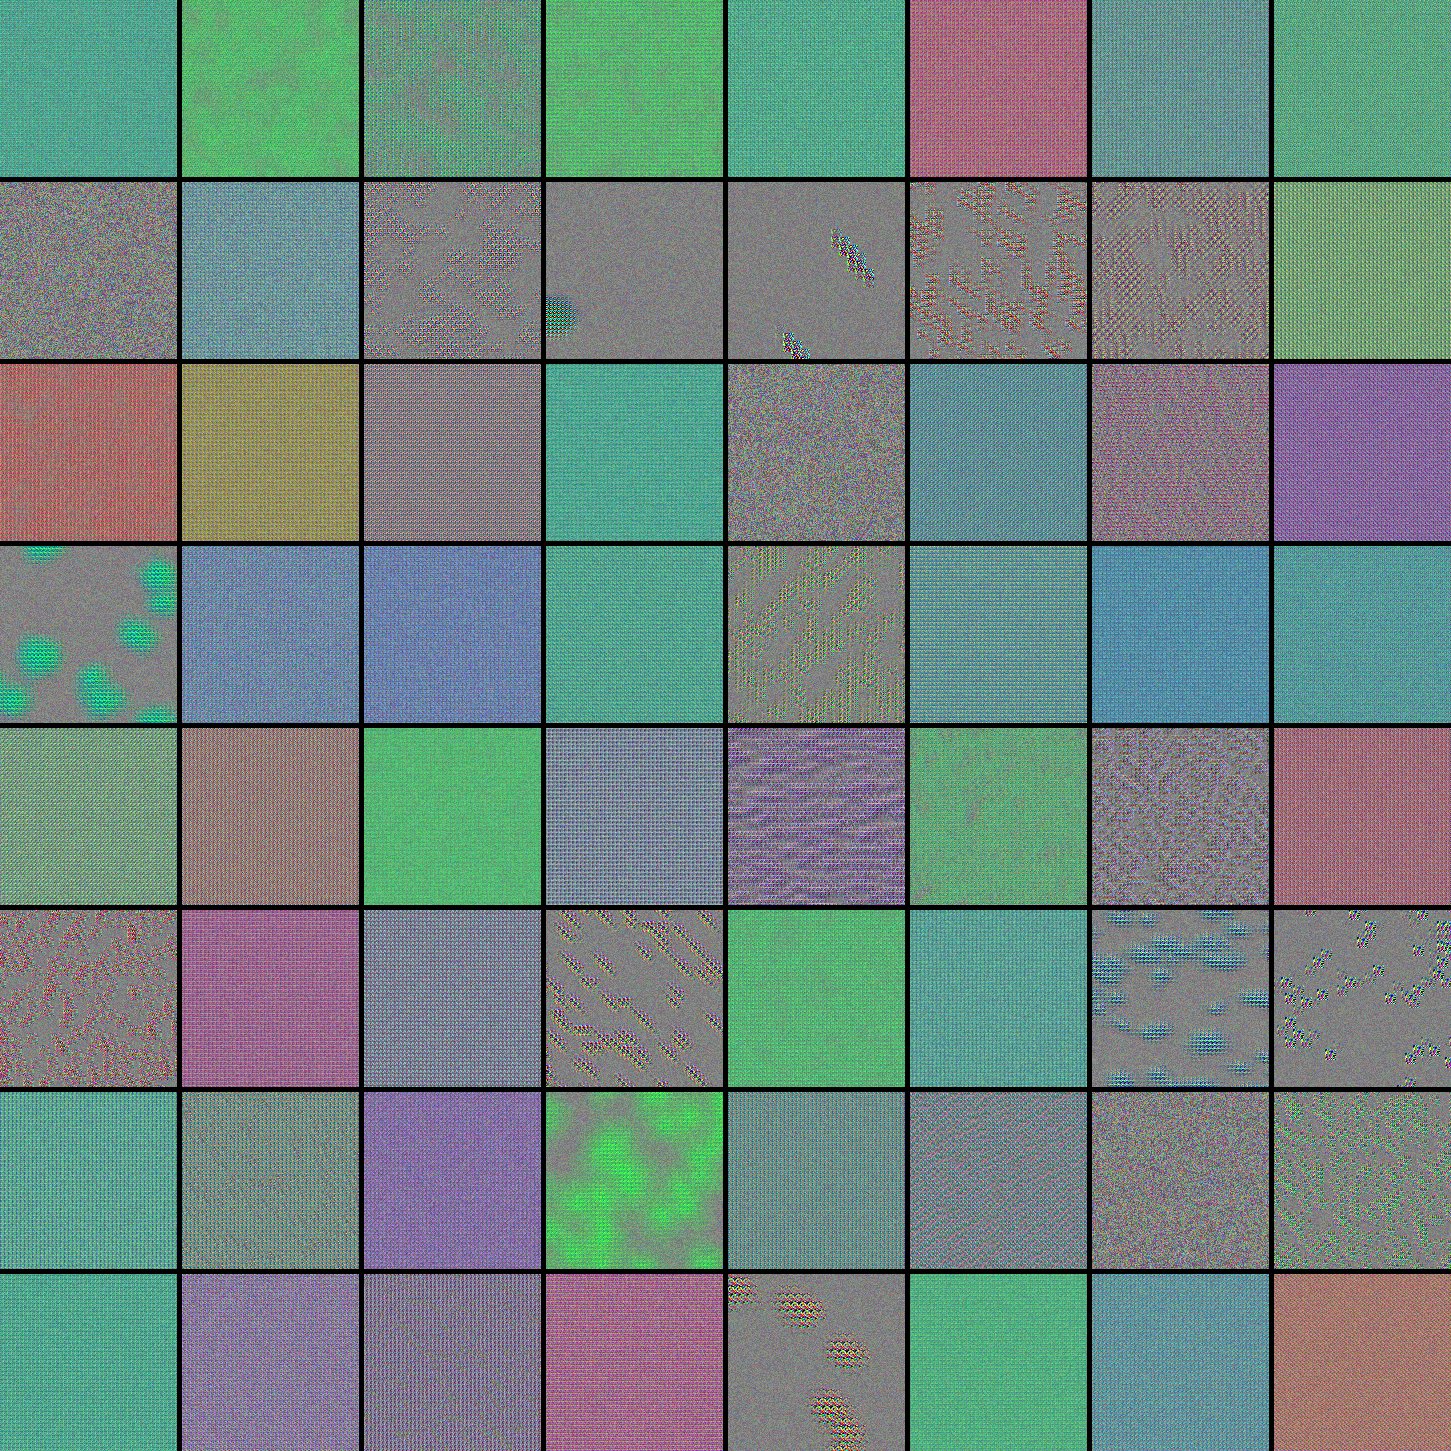

In [35]:
display(Image(f"lab7props/{layers_names[0]}_stitched_filters.png"))